Time series analysis. In this part, we focus on time series data of Stereo-seq Mouse embryo

In [2]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import seaborn as sns
import anndata as ad

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [3]:
adata = sc.read_h5ad("../../../../STAMP/Stereo_embryo/adata_clean.h5ad")

/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


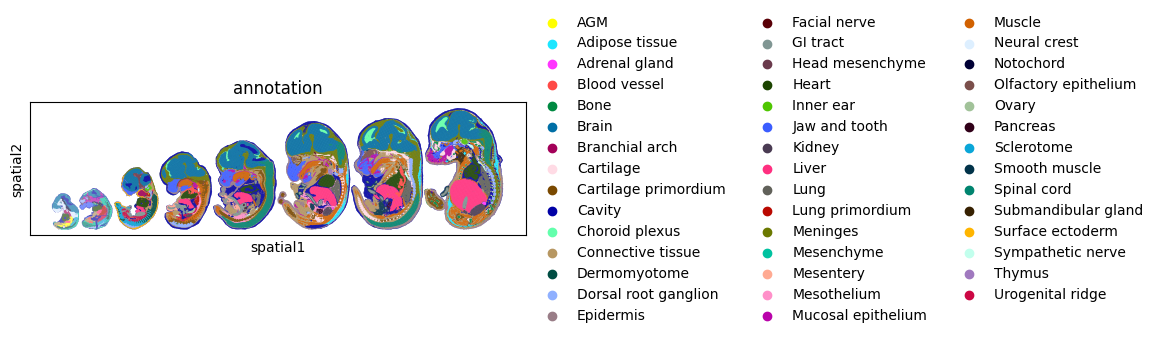

In [4]:
sctm.pl.spatial(adata, color="annotation", size=0.3)

We work with a downsampled data here

In [5]:
target_cells = 5000
cluster_key = "timepoint"
adatas = [
    adata[adata.obs[cluster_key] == clust]
    for clust in adata.obs[cluster_key].cat.categories
]

for dat in adatas:
    if dat.n_obs > 10000:
        num = round(0.1 * dat.n_obs) + target_cells
        sc.pp.subsample(dat, n_obs=num)

adata_downsampled = adatas[0].concatenate(*adatas[1:])

/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
adata_downsampled.obs.timepoint.value_counts()

timepoint
E16.5    17172
E15.5    16322
E14.5    15249
E13.5    12713
E12.5    10132
E10.5     8494
E11.5     8005
E9.5      5892
Name: count, dtype: int64

/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


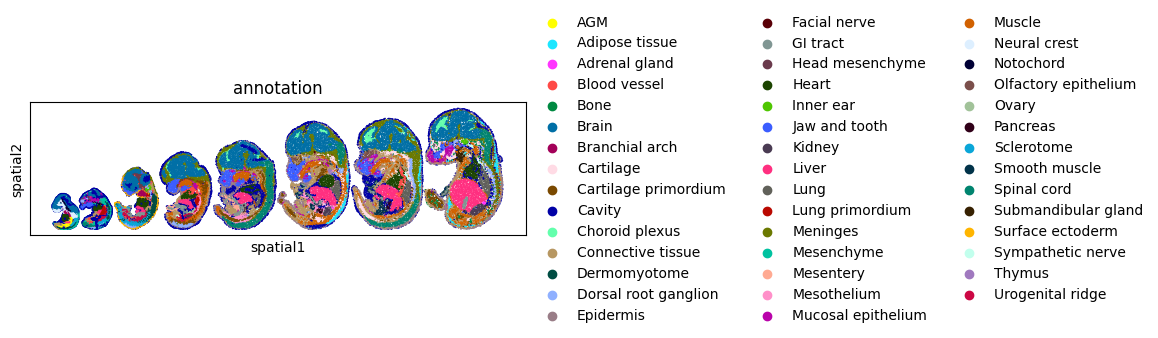

In [7]:
sctm.pl.spatial(adata_downsampled, color="annotation", size=3)

In [8]:
# We uses 10 neighbors here. Roughly (1/1000) * size
sq.gr.spatial_neighbors(adata_downsampled, n_neighs=10)

In [ ]:
model = sctm.stamp.STAMP(
    adata_downsampled,
    n_topics=40,
    layer="count",
    time_covariate_keys="time",
    gene_likelihood="nb",
)

# We uses a weighted sampler so that each batch is sampled equally
model.train(learning_rate=0.01, device="cuda:0", sampler="W", max_epochs=20)

In [10]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata_downsampled.obs[i] = topic_prop[i]

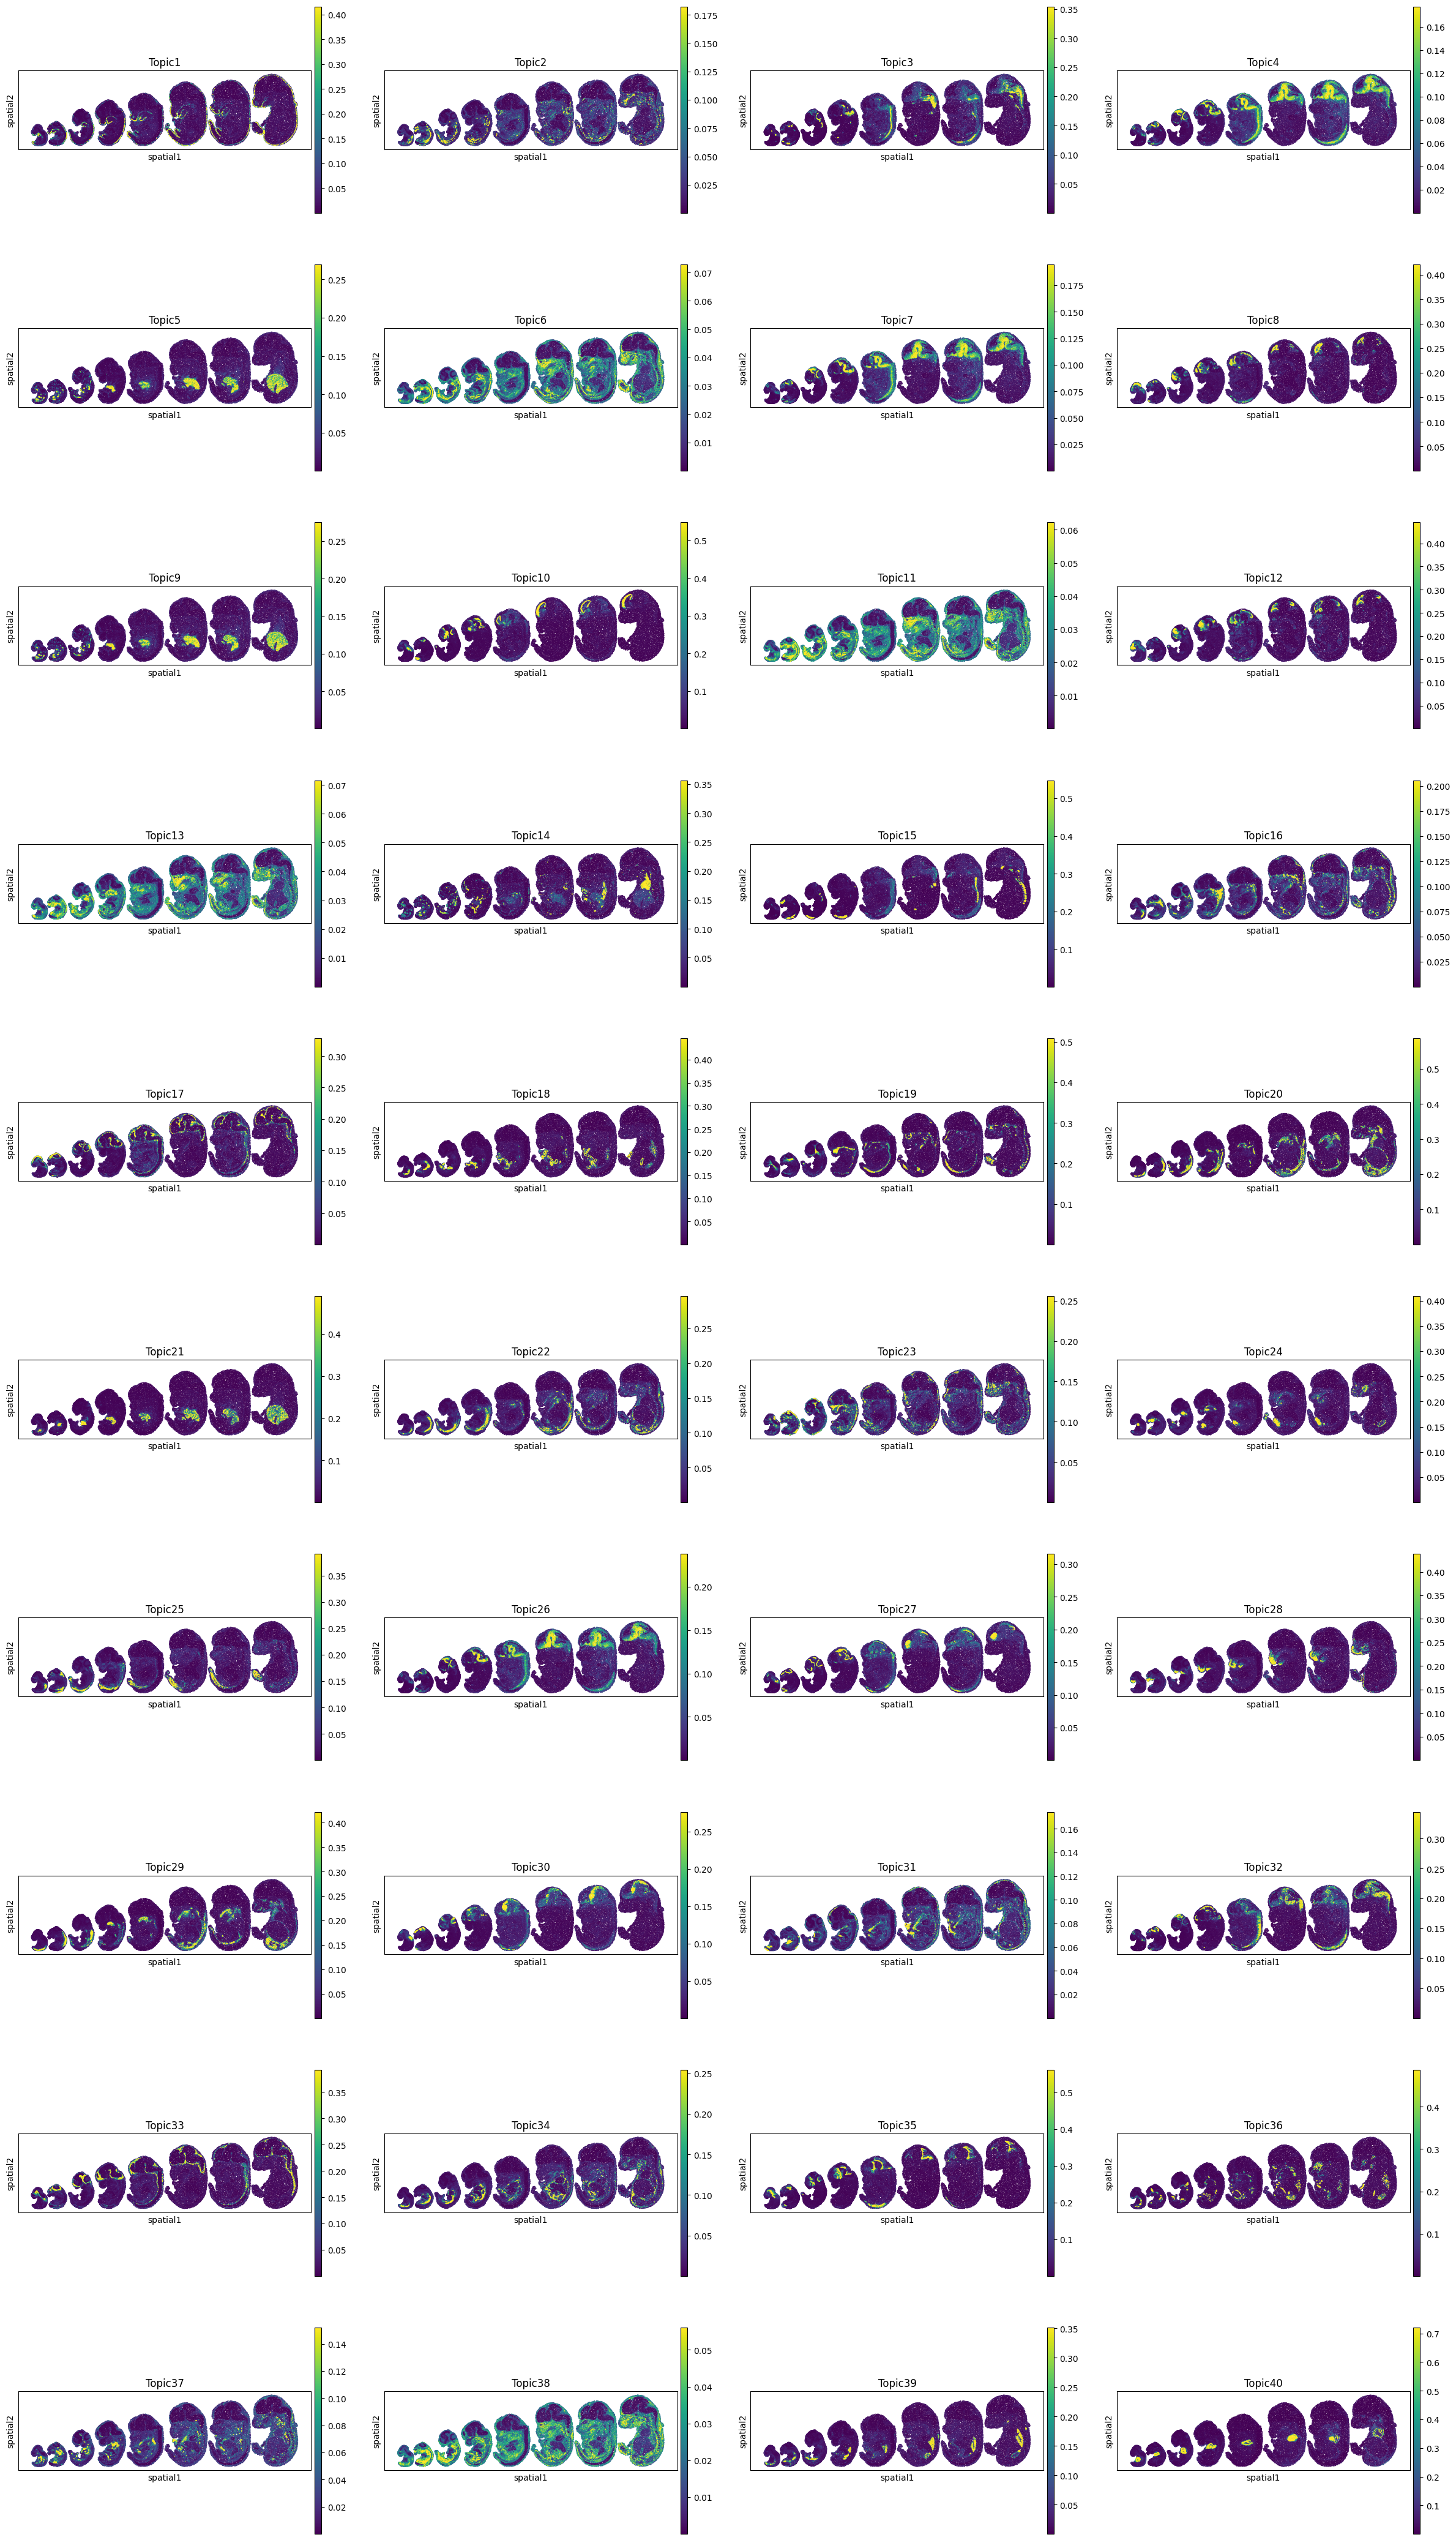

In [11]:
sctm.pl.spatial(adata_downsampled, color=topic_prop.columns, size=3, vmax="p99")

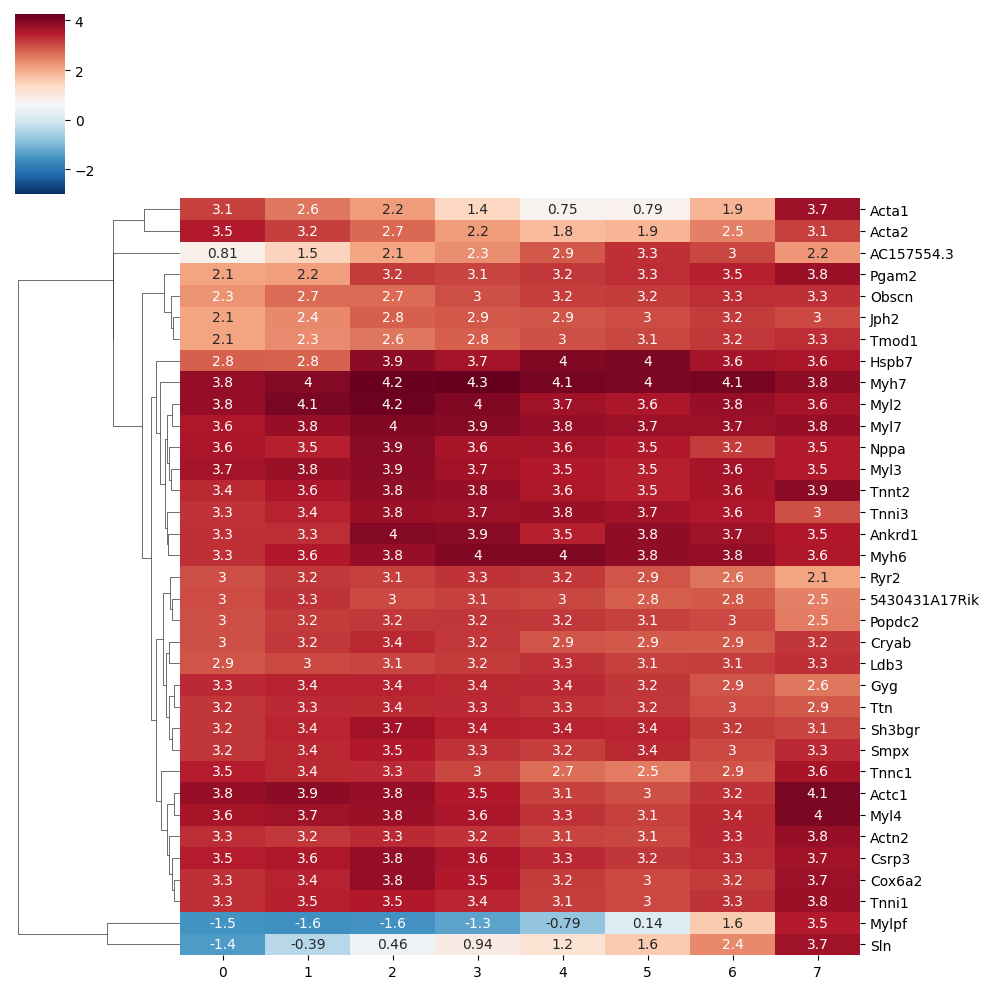

In [14]:
# Topic 5 is the heart
topic = "Topic40"
genes = []
for i in range(8):
    genes += beta.xs(topic, level=1).transpose().nlargest(20, i).index.tolist()
genes = np.unique(genes)

beta.xs(topic, level=1).rank(ascending=False, axis=1).transpose().loc[genes]

sns.clustermap(
    beta.xs(topic, level=1).transpose().loc[genes],
    col_cluster=False,
    cmap="RdBu_r",
    vmin=-3,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)